<a href="https://colab.research.google.com/github/leonmck-dsp-dev/nueraspeech/blob/main/nueraspeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%matplotlib inline

In [9]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
from torchaudio import transforms
import matplotlib.pyplot as plt
import IPython.display as ipd
import editdistance
from tqdm import tqdm

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [11]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


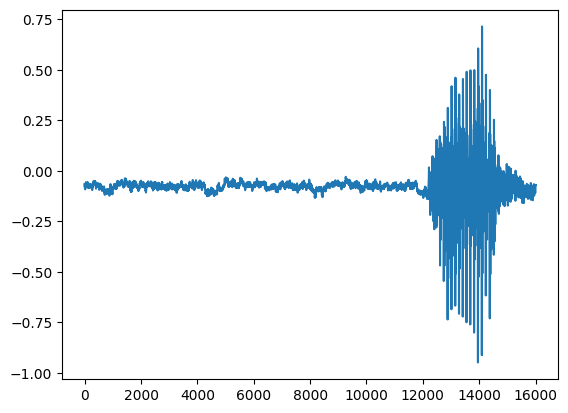

In [12]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [13]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [14]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [15]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

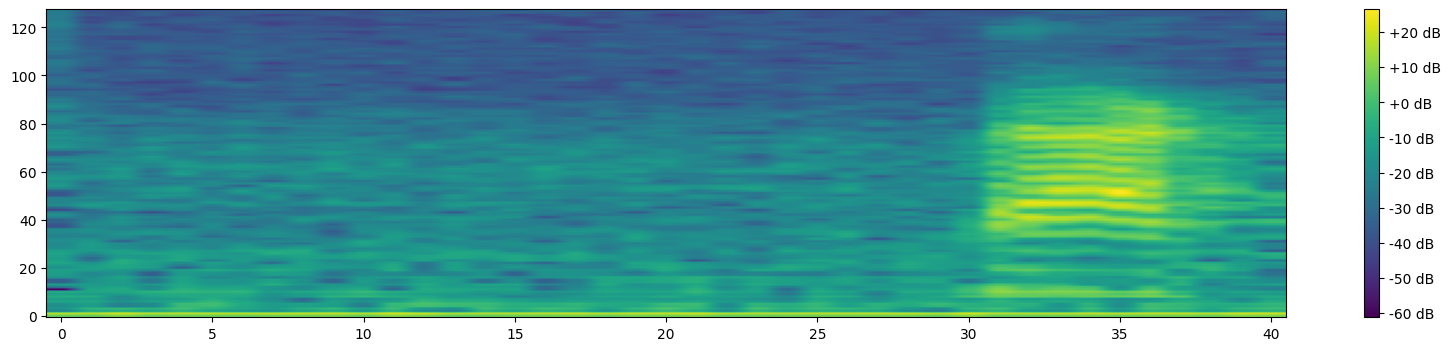

Shape of the Mel spectrogram: torch.Size([1, 128, 41])


In [16]:
new_sample_rate = 8000
import torchaudio
import random
import numpy as np

class SpecAugment:
    def __init__(self, freq_mask_param, time_mask_param, num_time_masks=1, num_freq_masks=1):
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.num_time_masks = num_time_masks
        self.num_freq_masks = num_freq_masks

    def __call__(self, specs):
        augmented_specs = []
        for spec in specs:
            # Frequency Masking
            for _ in range(self.num_freq_masks):
                num_freqs, num_frames = spec.shape
                f = random.randrange(0, self.freq_mask_param)
                f0 = random.randrange(0, num_freqs - f)
                spec[f0:f0 + f, :] = 0

            # Time Masking
            for _ in range(self.num_time_masks):
                num_freqs, num_frames = spec.shape
                t = random.randrange(0, self.time_mask_param)
                t0 = random.randrange(0, num_frames - t)
                spec[:, t0:t0 + t] = 0

            augmented_specs.append(spec)

        return torch.stack(augmented_specs)


# 1. Resample
resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
resampled_waveform = resampler(waveform)

# 2. Convert to Mel-spectrogram
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=new_sample_rate, n_mels=128)
mel_spectrogram = mel_transform(resampled_waveform)

# 3. Convert to dB scale
db_transform = torchaudio.transforms.AmplitudeToDB()
db_mel_spectrogram = db_transform(mel_spectrogram)

mel_spectrogram_transform = torch.nn.Sequential(
    torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate),
    torchaudio.transforms.MelSpectrogram(sample_rate=new_sample_rate, n_mels=128),
    torchaudio.transforms.AmplitudeToDB()
)

# Instantiate and apply
spec_augment = SpecAugment(freq_mask_param=30, time_mask_param=30)

# Display
plt.figure(figsize=(20, 4))
plt.imshow(db_mel_spectrogram[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(format="%+2.0f dB")
plt.show()

print("Shape of the Mel spectrogram:", mel_spectrogram.shape)
# Listen to the resampled audio
ipd.Audio(resampled_waveform.numpy(), rate=new_sample_rate)


In [17]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))

def index_to_label(tensor):
    # Convert tensor of indices into its string labels
    if tensor.dim() == 0:  # If tensor is a scalar
        return labels[tensor.item()]
    else:  # If tensor is not a scalar
        return [labels[index] for index in tensor.cpu().numpy()]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [18]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets
# hyperparameters

cnn = 1
rnn = 1
transformers = 2
head = 2
hidden_dim = 64
dropout = 0.1
dmodel = 128
batch_size = 256
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [19]:
print(torch.__version__)

2.0.1


# Nueraspeech model architecture
## Acoustic Model (Convolutional Layers)

### Convolutional Neural Networks (CNNs)
A convolutional layer employs a set of learnable filters, which are used to spatially convolve with the input data to produce feature maps. Mathematically, for a 1D input $x$ and a filter $h$, convolution is represented as:

$$
y(t) = (x * h)(t) = \sum_{a=-\infty}^{\infty} x(a)h(t-a)
$$

### Batch Normalization

Batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.

$$
\hat{x} = \frac{x - \text{E}[x]}{\sqrt{\text{Var}[x]+\epsilon}}
$$

Where:
- $\hat{x}$ is the normalized data.
- $\text{E}[x]$ is the mean of the batch data.
- $\text{Var}[x]$ is the variance of the batch data.
- $\epsilon$ is a small constant to avoid division by zero.

---

## Recurrent Layers (GRU Layers)

### Gated Recurrent Units (GRUs)

GRUs are a type of recurrent neural network (RNN) architecture. The GRU uses gating mechanisms (reset gate and update gate) to control the flow of information.

$$
r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)
$$
$$
z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)
$$
$$
\tilde{h}_t = \tanh(W x_t + r_t \odot (U h_{t-1} + b) + b')
$$
$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

Where:
- $r_t$ is the reset gate.
- $z_t$ is the update gate.
- $\tilde{h}_t$ is the candidate activation.
- $h_t$ is the output.
- $\sigma$ is the sigmoid function.
- $\odot$ is the element-wise multiplication.

---

## Transformer Attention

### Self Attention

The self-attention mechanism allows the model to weigh the significance of each part in a sequence based on its content. For a query $Q$, key $K$, and value $V$ set, the attention mechanism is defined as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$

Where $d_k$ is the dimension of the keys.

### Multi-head Attention

Instead of using one set of attention weights, multi-head attention uses multiple sets, allowing the model to focus on different parts of the input for different tasks or reasons.

---

## Residual Connections (ResBlocks)

Residual connections (or skip connections) allow for the direct flow of gradients during the backpropagation process. If $x$ is the input and $F(x)$ is the output after some layers, the residual connection is:

$$
\text{output} = x + F(x)
$$

This ensures that even as $F(x)$ learns the residuals (or errors), the original input is preserved.


In [20]:


# Variables you might want to change
experiment_name = "experiment2"
model_name = "nueraspeech"
layers = 'cnn layers:3 rnn layers:5 transformer layers:4 accuracy: 65% loss: 1.8 avg wer: 0.33 avg cer: 0.24 unimpaired speech  '
# Paths
base_path = os.path.join("./results", experiment_name)
plots_path = os.path.join(base_path, "plots")
models_path = os.path.join(base_path, "models")

# Create directories
os.makedirs(plots_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)

plot_file_path_loss = os.path.join(plots_path, "loss.png")
plot_file_path_accuracy = os.path.join(plots_path, "accourcy.png")
plot_file_path_pred = os.path.join(plots_path, "pred.png")
plot_file_path_errorrate = os.path.join(plots_path, "erro rate.png")
model_file_path = os.path.join(models_path, model_name + ".pth")

plot_file_path_loss, plot_file_path_errorrate, plot_file_path_pred, plot_file_path_accuracy, model_file_path


('./results/experiment2/plots/loss.png',
 './results/experiment2/plots/erro rate.png',
 './results/experiment2/plots/pred.png',
 './results/experiment2/plots/accourcy.png',
 './results/experiment2/models/nueraspeech.pth')

 | experiment  | num cnn | num rnn  | num tranformer | accuarcy |
|----------|----------|----------|----------|----------|
| 1 | 1 | 1 | 2 | 61% |
| 2 | 3| 5 | 4 |  65% |
| 3 | 5| 5 | 8 |    |
| 4 | 5| 7  | 16 |  |


In [21]:
 
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()

        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)
        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn(self.conv(x)))
        out = out + self.skip(x)
        return F.relu(out)
class AcousticModel(nn.Module):
    def __init__(self, n_input, n_channel, num_res_blocks=1):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(2)

        # Allow for multiple residual blocks
        self.resblocks = nn.Sequential(*[ResBlock(n_channel, n_channel) for _ in range(num_res_blocks)])

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.resblocks(x)
        return x

class RecurrentLayers(nn.Module):
    def __init__(self, n_channel, hidden_dim, num_gru_layers=1):
        super().__init__()
        self.gru = nn.GRU(n_channel, hidden_dim, num_layers=num_gru_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        x, _ = self.gru(x)
        return x
    
class Transformerblock(nn.Module):
    def __init__(self, d_model, heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads)  # multi-head attention layer
        self.norm1 = nn.LayerNorm(d_model) # layer normalization
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )   # feed-forward network

    def forward(self, x):
        # For self-attention, query, key, and value are all the same
        attended, _ = self.attention(x, x, x)  
        x = self.norm1(attended + x) # residual connection and layer normalization
        fedforward = self.feed_forward(x) 
        return self.norm2(fedforward + x) # residual connection and layer normalization

class StackedTransformer(nn.Module):
    def __init__(self, d_model, heads, N):
        super(StackedTransformer, self).__init__()
        self.layers = nn.ModuleList([Transformerblock(d_model, heads) for _ in range(N)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class nueraspeechASR(nn.Module):
    def __init__(self, n_input=1, n_output=35, n_channel=16, hidden_dim=64, dropout_rate=0.4, 
                 num_res_blocks=cnn, num_gru_layers=rnn, d_model=dmodel, heads=head, num_transformer_layers=transformers):
        super().__init__()


        self.acoustic_model = AcousticModel(n_input, n_channel, num_res_blocks=num_res_blocks) 
        self.dim_matching_conv = nn.Conv1d(n_channel, d_model, kernel_size=1)
        self.transformer_to_rnn_fc = nn.Linear(d_model, n_channel)  # n_channel is 16 in this context
        self.recurrent_layers = RecurrentLayers(n_channel, hidden_dim, num_gru_layers=num_gru_layers) 
        self.attention = StackedTransformer(d_model=hidden_dim * 2, heads=heads, N=num_transformer_layers)
        self.output_fc = nn.Linear(hidden_dim*2, n_output)
    
        self.dropout = nn.Dropout(dropout_rate)  
    def forward(self, x):
        x = self.acoustic_model(x)
        x = self.dim_matching_conv(x)
        x = x.permute(0, 2, 1)
        x = self.attention(x)
        x = self.transformer_to_rnn_fc(x)
        x = self.recurrent_layers(x)
        x = self.dropout(x)
        x = x[:, -1, :]
        x = self.output_fc(x) 
        return F.log_softmax(x, dim=1)


# Testing the model
n_input = 128
n_output = 35

model = nueraspeechASR(n_input=n_input, n_output=n_output)
print(model)

# Print number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters()):,} trainable parameters')

# Test
x = torch.randn(1, 128, 8000)
OUT = model(x)
print(OUT.shape)


nueraspeechASR(
  (acoustic_model): AcousticModel(
    (conv1): Conv1d(128, 16, kernel_size=(5,), stride=(2,))
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (resblocks): Sequential(
      (0): ResBlock(
        (conv): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (skip): Sequential()
      )
    )
  )
  (dim_matching_conv): Conv1d(16, 128, kernel_size=(1,), stride=(1,))
  (transformer_to_rnn_fc): Linear(in_features=128, out_features=16, bias=True)
  (recurrent_layers): RecurrentLayers(
    (gru): GRU(16, 64, batch_first=True, bidirectional=True)
  )
  (attention): StackedTransformer(
    (layers): ModuleList(
      (0-1): 2 x Transformerblock(
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuant

In [22]:
# @title Default title tex

n_epoch = 10
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress")

experiment_name = "experiment2"
model_name = models_path+"/nueraspeech.pth"

Training Progress:   0%|          | 0/84843 [00:00<?, ?it/s]

In [23]:
def train(model, epoch, log_interval):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.squeeze(1)  # This will remove the single channel dimension, turning [batch_size, 1, 128, 41] into [batch_size, 128, 41]

        # Preprocess the data with Mel-spectrogram transform
        data = mel_spectrogram_transform(data)

        # Apply SpecAugment (only during training)
        data = spec_augment(data)
        data = data.to(device)


        target = target.to(device)

        output = model(data)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())


In [24]:
def wer(s1, s2):

    b = set(s1 + s2)
    word2char = dict(zip(b, range(len(b))))

    w1 = [chr(word2char[w]) for w in s1]
    w2 = [chr(word2char[w]) for w in s2]

    return editdistance.eval(" ".join(w1), " ".join(w2)) / len(s2)
def cer(s1, s2): 
    s1 = " ".join(s1)
    s2 = " ".join(s2)

    return editdistance.eval(s1, s2) / len(s2)


def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)
wer_over_epochs = []
cer_over_epochs = []
correct_predictions_over_epochs = []

def test(model, epoch):
    model.eval()
    correct = 0
    total_wer, total_cer, total_samples = 0, 0, 0

    for data, target in test_loader:
        # Apply Mel-spectrogram transform
        data = mel_spectrogram_transform(data)

        # Remove channel dimension after applying mel transform
        data = data.squeeze(1)  # This will convert [batch_size, 1, 128, 41] into [batch_size, 128, 41]

        data = data.to(device)
        target = target.to(device)

        output = model(data)
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # Compute WER and CER
        pred_str = index_to_label(pred)  # Convert the prediction indices to string
        target_str = index_to_label(target)  # Convert target indices to string

        total_wer += wer(pred_str, target_str)
        total_cer += cer(pred_str, target_str)
        total_samples += 1

        # update progress bar
        pbar.update(pbar_update)

    avg_wer = total_wer / total_samples
    avg_cer = total_cer / total_samples


    accuracy = correct / len(test_loader.dataset)
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)")
    print(f"Average WER: {avg_wer:.4f}\nAverage CER: {avg_cer:.4f}\n")

    return avg_wer, avg_cer, correct, accuracy

In [25]:
log_interval = 20
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
model = model.to(device)


accuracy_over_epochs = []
for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    # Evaluate the model
    avg_wer, avg_cer, correct, accuracy = test(model, epoch)

    # Store the metrics for plotting or further analysis
    wer_over_epochs.append(avg_wer)
    cer_over_epochs.append(avg_cer)
    correct_predictions_over_epochs.append(correct)
    accuracy_over_epochs.append(accuracy)
    scheduler.step()
   # Save
    torch.save(model.state_dict(), model_name)
    print("saved")
# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

Training Progress:   0%|          | 0.0026666666666666666/84843 [00:00<3805:44:55, 161.48s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.549338


Training Progress:   0%|          | 0.021333333333333336/84843 [00:02<2892:40:19, 122.74s/it] 

KeyboardInterrupt: 

## Metrics

### Word Error Rate (WER)

Word Error Rate (WER) is a standard metric used to measure the performance of an automatic speech recognition system. It represents the ratio of incorrect words to the total number of words in the reference transcription:

$$
\text{WER} = \frac{\text{Substitutions + Insertions + Deletions}}{\text{Total number of words in reference}}
$$

### Character Error Rate (CER)

Character Error Rate (CER) is similar to WER but measures errors at the character level. It represents the ratio of incorrect characters to the total number of characters in the reference transcription:

$$
\text{CER} = \frac{\text{Substitutions + Insertions + Deletions}}{\text{Total number of characters in reference}}
$$

### Accuracy

Accuracy is a standard metric used to evaluate classification models. It is defined as the ratio of correct predictions to the total number of predictions:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

### Loss

The loss function quantifies how well the predicted outputs agree with the actual labels. For classification problems, a common loss function is the negative log-likelihood loss:

$$
\text{Loss} = -\log \left( \frac{\text{Probability of the Correct Class}}{\text{Sum of Probabilities for All Classes}} \right)
$$

These metrics provide a comprehensive evaluation of the model's performance, allowing for better understanding and optimization.


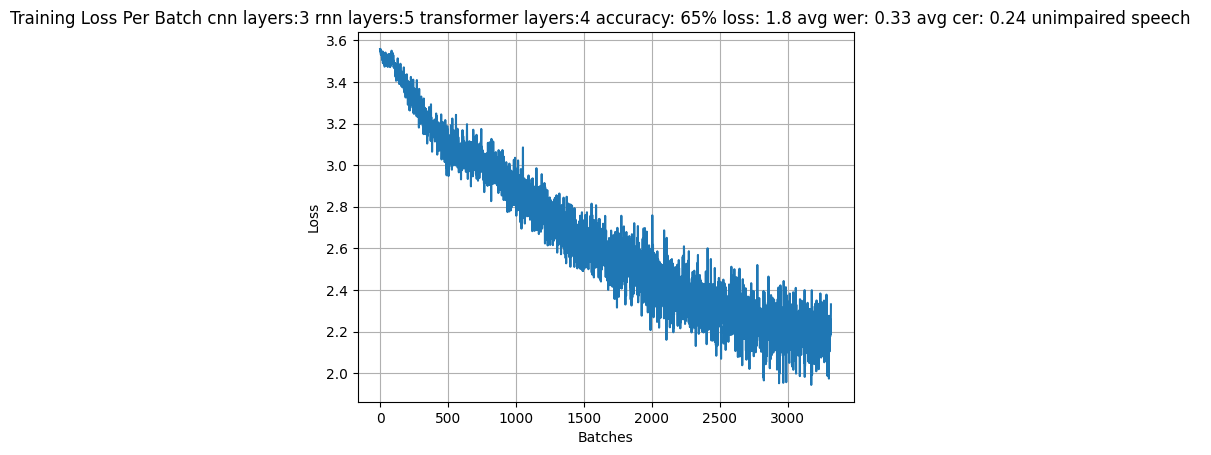

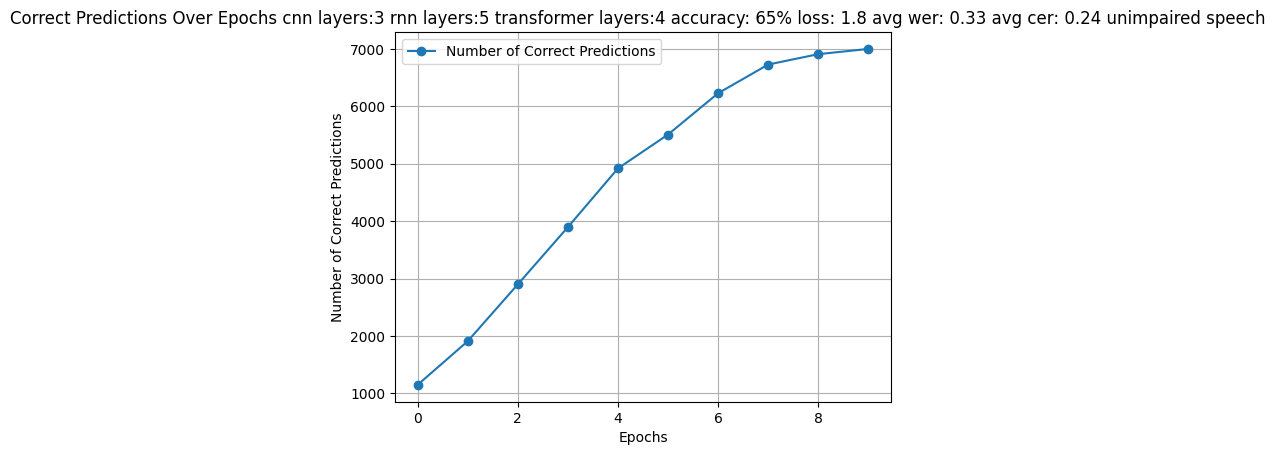

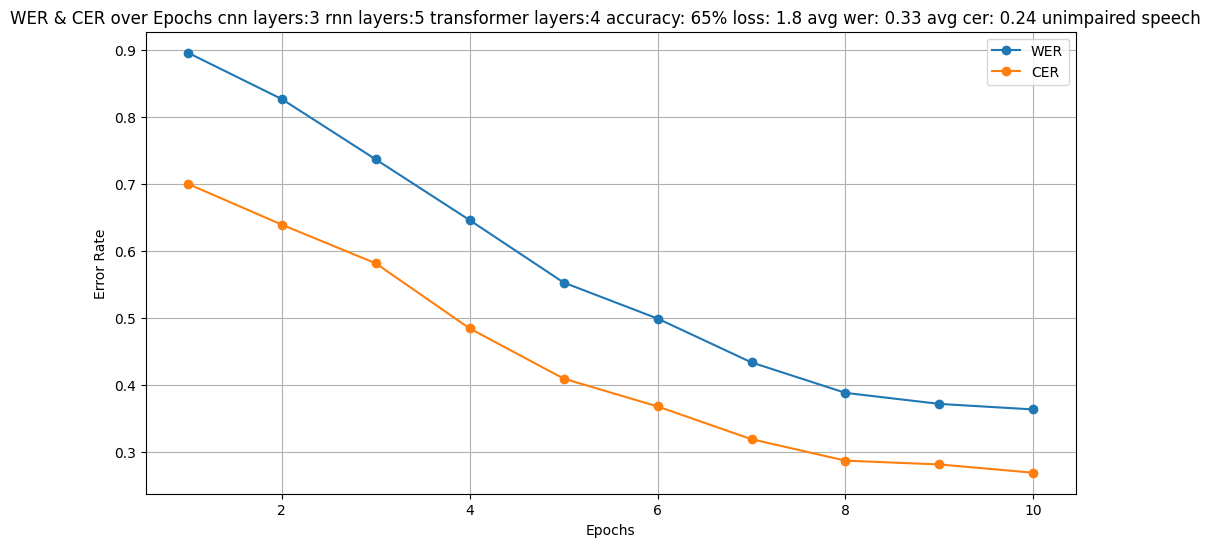

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

NameError: name 'transform' is not defined

In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):    output = predict(waveform)
if output != utterance:
      ipd.Audio(waveform.numpy(), rate=sample_rate)
      print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

In [ ]:
!pip install sounddevice

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.9 MB/s eta 0:00:00a 0:00:01


In [41]:
import sounddevice as sd
import numpy as np
import torch
import torchaudio.transforms as T
import random
import matplotlib.pyplot as plt
import torch

# Variables you might want to change 
pth = "results/experiment1/models/nueraspeech.pth"
model.load_state_dict(torch.load(pth))
model.eval()  # Set the model to evaluation mode
duration = 2  # seconds
# Defining functions 

def record_audio():
    input("Press Enter to start recording...")
    print("Recording...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype=np.float32)
    sd.wait()
    print("Recording done.")
    return torch.tensor(audio).squeeze()

def live_validate(model, features, true_label_text):
    model.eval()
    with torch.no_grad():
        # Model forward pass
        outputs = model(features)

        # Get predicted label
        predicted_label_index = outputs.argmax(dim=1).item()
        predicted_label_text = labels[predicted_label_index]

        # Compute WER and CER
        wer_score = wer([true_label_text], [predicted_label_text])
        cer_score = cer(true_label_text, predicted_label_text)

    return predicted_label_text, wer_score, cer_score

# Lists 
# to store metrics for plotting
wer_over_epochs = []
cer_over_epochs = []
loss_over_epochs = []
accuracy_over_epochs = []
batch_size = 5



num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    for _ in range(len(labels) // batch_size):
        # Record multiple samples
        waveforms = []
        true_labels = []
        for _ in range(batch_size):
            true_label_index = random.randint(0, len(labels) - 1)
            true_label_text = labels[true_label_index]
            print(f"Please speak the label: {true_label_text}")
            waveform = record_audio()
            waveforms.append(waveform)
            true_labels.append(true_label_index)

        # Preprocess the data
        features = [mel_spectrogram_transform(w) for w in waveforms]
        features = torch.stack(features)
        true_labels = torch.tensor(true_labels)

        # Model forward pass
        outputs = model(features)

        # Compute loss
        loss = F.nll_loss(outputs, true_labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
# Compute accuracy
        pred = outputs.argmax(dim=1, keepdim=True)
        correct = pred.eq(true_labels.view_as(pred)).sum().item()
        accuracy = correct / batch_size

        print("Please provide an audio sample for validation:")
        val_waveform = record_audio()
        val_features = mel_spectrogram_transform(val_waveform)
        val_features = val_features.squeeze(0).unsqueeze(0)  # Adjusting dimensions
        predicted_label, wer_score, cer_score = live_validate(model, val_features, true_label_text)

        print(f"Model's prediction: {predicted_label}\nWER: {wer_score}\nCER: {cer_score}\n")
    # Store metrics
    loss_over_epochs.append(loss.item())
    accuracy_over_epochs.append(accuracy)
    wer_over_epochs.append(wer_score)
    cer_over_epochs.append(cer_score)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy*100:.2f}%\n")


    torch.save(model.state_dict(), pth)
    print("saved")

# Plot metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].plot(loss_over_epochs, label='Training Loss')
axs[0, 0].set_title('Training Loss')
axs[0, 1].plot(accuracy_over_epochs, label='Training Accuracy')
axs[0, 1].set_title('Training Accuracy')
axs[1, 0].plot(wer_over_epochs, label='WER')
axs[1, 0].set_title('Word Error Rate (WER)')
axs[1, 1].plot(cer_over_epochs, label='CER')
axs[1, 1].set_title('Character Error Rate (CER)')

for ax in axs.flat:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


Please speak the label: sheila
Recording...
Recording done.
Please speak the label: zero
Recording...
Recording done.
Please speak the label: bed
Recording...
Recording done.
Please speak the label: visual
Recording...
Recording done.
Please speak the label: eight
Recording...
Recording done.
Please provide an audio sample for validation:
Recording...
Recording done.
Model's prediction: six
WER: 1.0
CER: 1.2

Please speak the label: on
Recording...
Recording done.
Please speak the label: eight
Recording...
Recording done.
Please speak the label: two
Recording...
Recording done.
Please speak the label: follow
Recording...
Recording done.
Please speak the label: left
Recording...
Recording done.
Please provide an audio sample for validation:
Recording...
Recording done.
Model's prediction: left
WER: 0.0
CER: 0.0

Please speak the label: three
Recording...
Recording done.
Please speak the label: three
Recording...
Recording done.
Please speak the label: right
Recording...
Recording done.


KeyboardInterrupt: 

In [38]:

        print("Please provide an audio sample for validation:")
        val_waveform = record_audio()
        val_features = mel_spectrogram_transform(val_waveform)
        val_features = val_features.squeeze(0).unsqueeze(0)  # Adjusting dimensions
        predicted_label, wer_score, cer_score = live_validate(model, val_features, true_label_text)

        print(f"Model's prediction: {predicted_label}\nWER: {wer_score}\nCER: {cer_score}\n")

Please provide an audio sample for validation:
Recording...
Recording done.
Model's prediction: cat
WER: 1.0
CER: 1.4



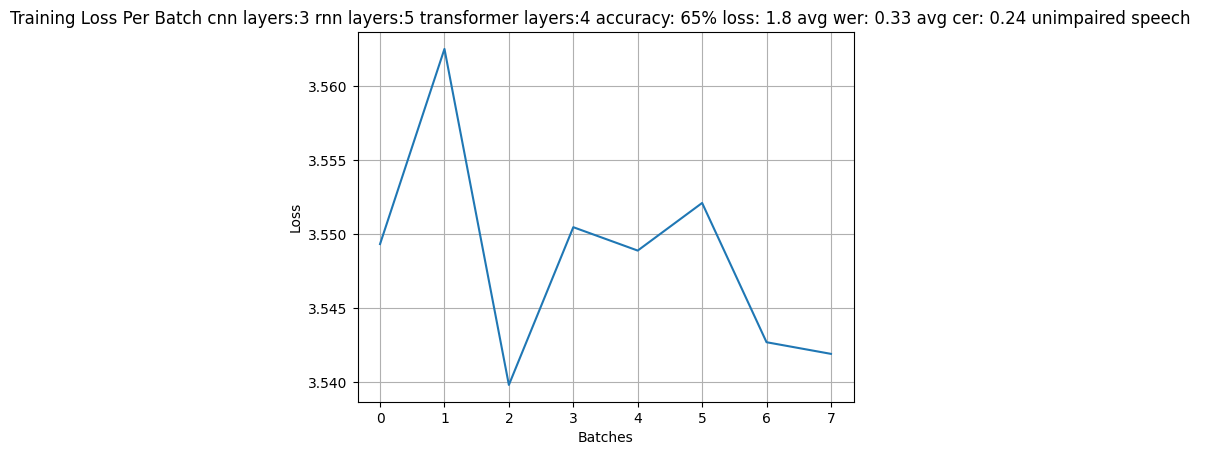

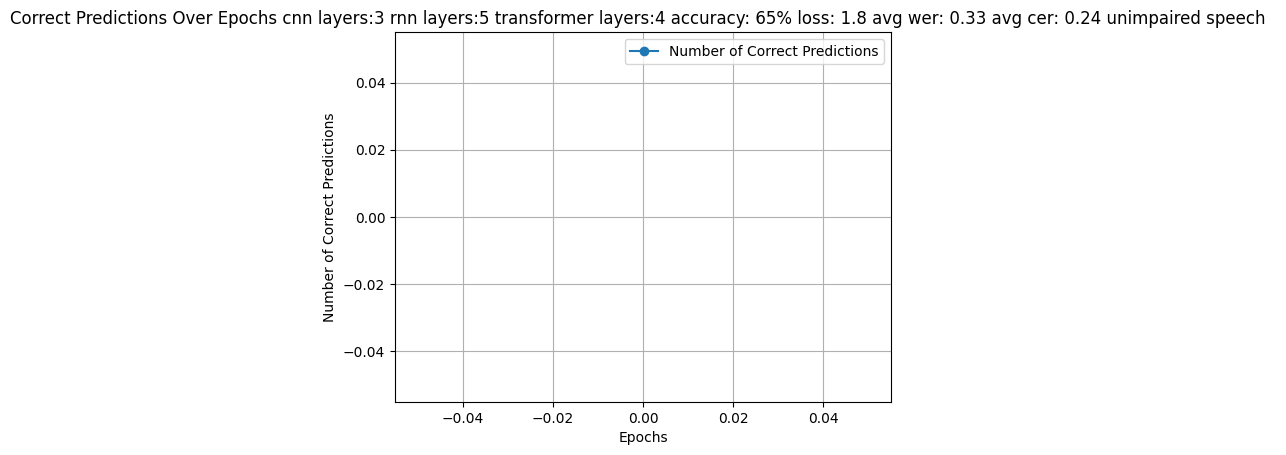

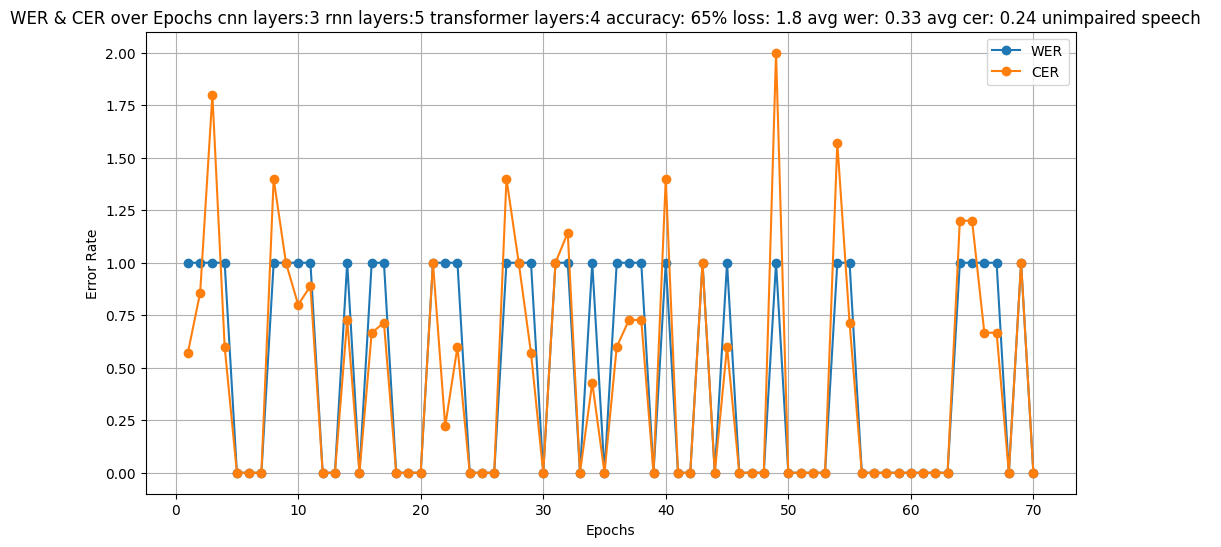

In [32]:



# Let's plot the training metrics versus the number of iteration.
# WER Plotvimport matplotlib.pyplot as plt
epochs = list(range(1, 10))

#loss
plt.plot(losses)
plt.title('Training Loss Per Batch ' + layers)
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.grid()
plt.show()



#pred
plt.plot(correct_predictions_over_epochs, marker='o', label='Number of Correct Predictions')
plt.xlabel('Epochs')
plt.ylabel('Number of Correct Predictions')
plt.title('Correct Predictions Over Epochs '+ layers)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
# Plot WER# Assuming wer_over_epochs and cer_over_epochs have been populated correctly during training:
epochs_range = list(range(1, len(wer_over_epochs) + 1))

plt.plot(epochs_range, wer_over_epochs, label='WER', marker='o')

plt.plot(epochs_range, cer_over_epochs, label='CER', marker='o')
plt.title('WER & CER over Epochs ' + layers)
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()



 